## Importing swe-BERT for initial training

In [6]:
import torch
import numpy as np
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# collab command to install transformers
# !pip install transformers
# !pip install tqdm


In [7]:
from torch.utils.data import Dataset


import re
def clean_txt (text):
  text = re.sub("¹", "", text)
  text=re.sub("(\\W)+","  ", text)
  return text


class SNLIDataset(Dataset):

    def __init__(self, filename, max_size=None):
        super().__init__()
        self.xs = []
        self.ys = []
        self.sentence_lengths = np.array([])
        count = 0
        with open(filename, encoding="utf-8") as source:
            for i, line in enumerate(source):
                if i == 0:
                  continue
                # print(line)
                if max_size and i >= max_size:
                    break
                try:
                  sentence, sentiment_value = line.rstrip().split('|') # Delimeter to be chosen
                  count += 1
                except:
                  print( "Error when processing the following data ", [line.rstrip().split('|')])
                # print(sentence)
                self.xs.append(clean_txt(sentence))
                self.ys.append(int(sentiment_value)) # make sure negative/neutral/positive is labelled correct
                self.sentence_lengths = np.append(self.sentence_lengths, len(sentence.split(" ")))

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]

    def __len__(self):
        return len(self.xs)

## Create all datasets

In [8]:
# financial_news_train_dataset = SNLIDataset('./Financial Data/financial_phrases_labeled_psv_train.csv')
# financial_news_test_dataset = SNLIDataset('./Financial Data/financial_phrases_labeled_psv_test.csv')
amazon_review_dataset = SNLIDataset('./amazon-review-data/amazon_review_data_psv.csv')
# hp_n, mp_n, neg_n, neu_n = SNLIDataset('./sweOnlyProcData/highPosNews.txt'), SNLIDataset('./sweOnlyProcData/mediumPosNews.txt'), SNLIDataset('./sweOnlyProcData/negativeNews.txt'), SNLIDataset('./sweOnlyProcData/neutralNews.txt')

# data = financial_news_train_dataset[121]


## Dataset analysis
Here we analyze the length distribution for each dataset

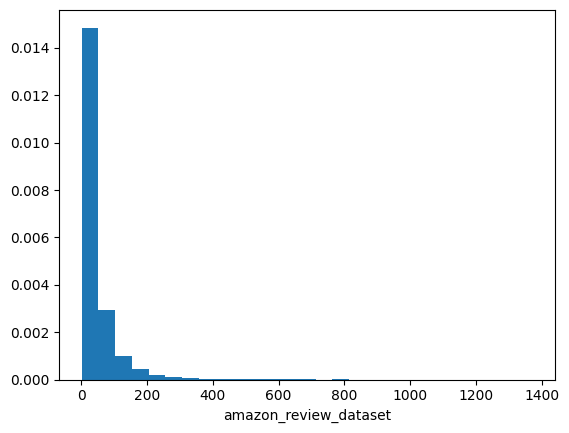

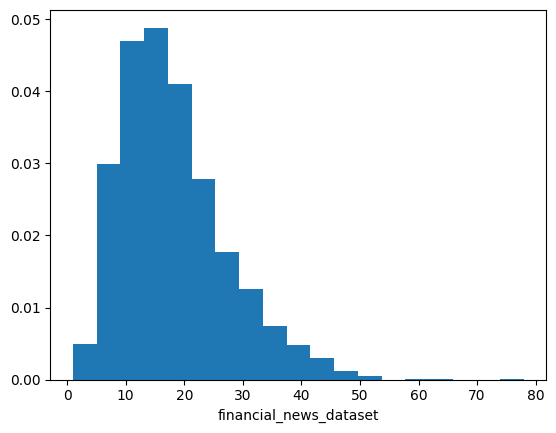

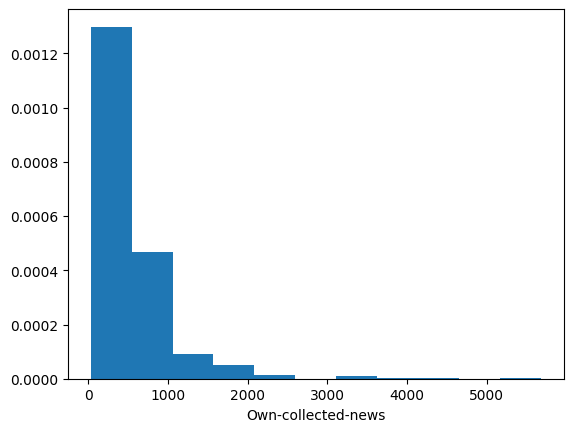

In [ ]:
import matplotlib.pyplot as plt

def plot_data_length(sentence_lengths, datasetName, resolution=1):
    plot_data_length.total_plots += 1
    plt.figure(plot_data_length.total_plots)
    plt.hist(sentence_lengths, bins=int(np.max(sentence_lengths)*resolution), density=True)
    plt.xlabel(datasetName)
plot_data_length.total_plots = 0
plot_data_length(amazon_review_dataset.sentence_lengths, "amazon_review_dataset", 1/50)
plot_data_length(np.concatenate([financial_news_test_dataset.sentence_lengths, financial_news_train_dataset.sentence_lengths]), "financial_news_dataset", 1/4)
plot_data_length(np.concatenate([hp_n.sentence_lengths, mp_n.sentence_lengths, neg_n.sentence_lengths, neu_n.sentence_lengths]), "Own-collected-news", 1/500)


## Import swedish bert

In [9]:
!pip install transformers
from transformers import BertTokenizer, BertForSequenceClassification, BertModel

tokenizer = BertTokenizer.from_pretrained('KB/bert-base-swedish-cased', do_lower_case=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
tokenized = tokenizer(text=financial_news_train_dataset[1][0], padding='longest', return_tensors='pt')
print(financial_news_train_dataset[1][0])
print(tokenized.input_ids)
print(tokenized)

Motsvarande  ökning  av  aktiekapitalet  totalt  300  00  euro  registrerades  i  det  finska  handelsregistret  den  8  maj  2008  
tensor([[    2,  3487,  7320,    65, 32700,  3581,  3029,   207,  3605, 39661,
            31,    82,  5723, 13788, 23679,    97,   319,  1425,  3003,     3]])
{'input_ids': tensor([[    2,  3487,  7320,    65, 32700,  3581,  3029,   207,  3605, 39661,
            31,    82,  5723, 13788, 23679,    97,   319,  1425,  3003,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


### Define colate function that tokenizes

In [10]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if text1.shape[0]//150 >0:
    n = text1.shape[0]//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1[:200]
      l_total.append(l_parcial)
    else:
      l_parcial = text1[w*150:w*150 + 200]
      l_total.append(l_parcial)
  return l_total

In [18]:
def tensor_split(text1):
  l_total = []
  l_parcial = []
  cls_tokens = torch.unsqueeze(torch.as_tensor([2]* text1.shape[0]), dim=1)
  if text1.shape[1]//150 >0:
    n = text1.shape[1]//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = torch.concat([cls_tokens, text1[:,:200]], dim=1)
      l_total.append(l_parcial)
    else:
      l_parcial = torch.concat([cls_tokens, text1[:,w*150:w*150 + 200]], dim=1)
      l_total.append(l_parcial)
  return l_total





In [12]:
def our_collate_fn(data):
    x = [a[0] for a in data]
    y = [a[1] for a in data]
    tokenized = tokenizer(text=x, padding='longest', return_tensors='pt')

    return tokenized['input_ids'], torch.as_tensor(y), tokenized['attention_mask']

In [13]:
from torch.utils.data import DataLoader

def create_training_examples(dataset, batch_size = 64):
    batch_sort_order = np.array_split(dataset.sentence_lengths.argsort()[::-1], round(len(dataset) / batch_size))
    tokenized_train_data = DataLoader(dataset, collate_fn=our_collate_fn, batch_sampler=batch_sort_order) #

    for bindex, (bx, by, ba) in enumerate(tokenized_train_data):
        yield tensor_split(bx), tensor_split(ba), by
                




In [14]:
import torch.nn as nn

rnn = nn.LSTM(10, 20, batch_first = True)
input = torch.randn(3, 5, 10)
h0 = torch.randn(1, 3, 20)
c0 = torch.randn(1, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

print("Input shape: {}".format([*input.shape]))
print("Output shape: {}".format([*output.shape]))
print("Last hidden state shape: {}".format([*hn.shape]))

Input shape: [3, 5, 10]
Output shape: [3, 5, 20]
Last hidden state shape: [1, 3, 20]


In [22]:
import torch.nn as nn


class DocBert():
    def __init__(self, bert, hidden_dim, num_labels):
        self.bert =  bert # INTE BertForSequenceClassification
        self.lstm = nn.LSTM(bert.config.hidden_size, hidden_dim)
        # Input [Batch_size, sequence_length, input_size]
        # Output [1, batch_size, hidden_dim]
        self.linear = nn.Linear(hidden_dim, num_labels)
    def forward(self, x_seqs, a_seqs):
      bertified_seqs = []
      for x_seq, a_seq in zip(x_seqs, a_seqs):
        print(self.bert.forward(x_seq, a_seq).last_hidden_state[:,0,:].shape) #Only get the embedding of the [CLS]-token
      #   bertified_seqs.append()
      # print(torch.concat(bertified_seqs, dim=1).shape)

    def predict(self, ):
      pass

docbert = DocBert(BertModel.from_pretrained('KB/bert-base-swedish-cased'), 20, 3)
for x_seqs, a_seqs, by in create_training_examples(amazon_review_dataset, batch_size=10):
  docbert.forward(x_seqs, a_seqs)
  break



Some weights of the model checkpoint at KB/bert-base-swedish-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([10, 768])
torch.Size([10, 768])
torch.Size([10, 768])
torch.Size([10, 768])
torch.Size([10, 768])
torch.Size([10, 768])
torch.Size([10, 768])
torch.Size([10, 768])


KeyboardInterrupt: ignored

#### Functions for training and testing a model

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm
def train_model(train_data, batch_size):
  batch_sort_order = np.array_split(train_data.sentence_lengths.argsort()[::-1], round(len(train_data) / batch_size))
  tokenized_train_data = DataLoader(train_data, collate_fn=our_collate_fn, batch_sampler=batch_sort_order) #
  
  # print(tokenized_train_data)
  # for batch in tokenized_train_data:
  #     for sent_pair in batch[0]:
  #       print(sent_pair)
  #     print(batch)
  #     break
  

  model = BertForSequenceClassification.from_pretrained('KB/bert-base-swedish-cased', num_labels=3)
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
  # softmax = torch.nn.Softmax(dim=1)
  epochs = 1

  for _ in range(epochs):
    model.train()

    with tqdm(total=len(train_data)) as pbar:

      for bindex, (bx, by, ba) in enumerate(tokenized_train_data):
        bx, by, ba = bx.to(device), by.to(device), ba.to(device)
        optimizer.zero_grad()
        # forward pass
        train_output = model(bx, labels=by, attention_mask=ba)
        # backward pass
        train_output.loss.backward()
        optimizer.step()
        pbar.update(len(bx))
  return model

def evaluate_model(model, valid_data, batch_size):
    batch_sort_order = np.array_split(valid_data.sentence_lengths.argsort()[::-1], round(len(valid_data) / batch_size))
    tokenized_valid_data = DataLoader(valid_data, batch_sampler=batch_sort_order, collate_fn=our_collate_fn)
    model.eval()
    valids = []
    for bx, by, ba in tokenized_valid_data:
      with torch.no_grad():
        bx, by, ba = bx.to(device), by.to(device), ba.to(device)
        # forward pass
        try:
          eval_output = model(bx, attention_mask=ba)
          guess = torch.argmax(eval_output.logits, dim=1)
          valids.append(sum(guess == by)/len(by))
        except Exception as e:
          print(bx.shape, by.shape)
          print(ba.shape)
          print(e)
        
    print('Accuracy: {}'.format(sum(valids)/len(valids)))


## Train and save the financial model

In [ ]:
financial_trained_model = train_model(financial_news_train_dataset, 64)
evaluate_model(financial_trained_model, financial_news_test_dataset)
financial_trained_model.save_pretrained("./financial_trained_model")

KeyboardInterrupt: ignored

## Load the financial model and evaluate it on similar test-data 
accuracy should be 88%+

In [ ]:
loadedModel = BertForSequenceClassification.from_pretrained("./financial_trained_model/")
evaluate_model(loadedModel, financial_news_test_dataset, 32)

Accuracy: 0.8862680196762085


In [ ]:
evaluate_model(loadedModel, amazon_review_dataset, 16)

Accuracy: 0.39497217535972595
